### imports:

In [52]:
import os
import torchaudio
from torch.utils.data import Dataset
import random
import torch
import torchaudio.transforms as T
import noisereduce as nr
from tqdm import tqdm
import numpy as np
import scipy.signal
import librosa
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from torch.utils.data import DataLoader
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


### DATASET CLASS:

In [5]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, task="gender", transform=None, feature_extractor=None, n_persons=None, seed=42, 
                 use_preprocessed=False, preprocessed_dir="preprocessed",
                 features_to_extract=None, segment_length=None, segment_overlap=None, **feature_params):
        """
        Args:
            root_dir (str): Path to the directory containing the audio files.
            task (str): The task to perform. Options are "gender" or "owner".
            transform (callable, optional): Optional transform to be applied on a sample.
            feature_extractor (callable, optional): Function to extract features from the waveform.
            n_persons (int, optional): Number of unique persons (studentIDs) to include for owner classification.
            seed (int, optional): Seed for reproducibility when selecting N persons.
            use_preprocessed (bool, optional): Whether to use preprocessed data if available.
            preprocessed_dir (str, optional): Directory containing preprocessed features.
        """
        self.root_dir = root_dir
        self.task = task
        self.transform = transform
        self.feature_extractor = feature_extractor
        self.n_persons = n_persons
        self.seed = seed
        self.use_preprocessed = use_preprocessed
        self.preprocessed_dir = preprocessed_dir
        self.features_to_extract = features_to_extract or []
        self.segment_length = segment_length
        self.segment_overlap = segment_overlap
        self.feature_params = feature_params

        self.data = []
        self.student_ids = set()

        # Load and parse filenames
        for file in os.listdir(root_dir):
            if file.endswith(".mp3"):
                parts = file[:-4].split("_")  # Remove .mp3 and split by _

                # Validate file naming format
                if len(parts) == 4 and parts[0].startswith("HW") and \
                   (parts[1] == "intro" or parts[1].startswith("Q")) and \
                   parts[3] in ["male", "female"]:

                    try:
                        homework_number = int(parts[0][2:])
                        question_number = None if parts[1] == "intro" else int(parts[1][1:])
                        student_id = parts[2]
                        gender = parts[3]

                        self.data.append({
                            "file_path": os.path.join(root_dir, file),
                            "homework_number": homework_number,
                            "question_number": question_number,
                            "student_id": student_id,
                            "gender": gender
                        })

                        self.student_ids.add(student_id)
                    except ValueError:
                        # Skip files with invalid formats
                        continue

        if task == "owner" and n_persons is not None:
            random.seed(seed)
            selected_ids = random.sample(self.student_ids, n_persons)
            self.data = [item for item in self.data if item["student_id"] in selected_ids]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.use_preprocessed and self.preprocessed_dir:
            preprocessed_path = os.path.join(self.preprocessed_dir, os.path.basename(sample["file_path"]))
            if os.path.exists(preprocessed_path):
                return torchaudio.load(preprocessed_path)

        file_path = sample["file_path"]

        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)

        # Resample to a consistent rate
        target_sample_rate = 16000
        if sample_rate != target_sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
            waveform = resampler(waveform)
            sample_rate = target_sample_rate

        # Apply noise reduction
        waveform = nr.reduce_noise(y=waveform.numpy(), sr=sample_rate)
        waveform = torch.tensor(waveform)

        # Normalize waveform
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-7)

        # Apply transform if specified
        if self.transform:
            waveform = self.transform(waveform)

        # Extract features if feature_extractor is specified
        if self.feature_extractor:
            features = self.feature_extractor(waveform, sample_rate)
        else:
            features = waveform

        if self.task == "gender":
            label = 0 if sample["gender"] == "male" else 1
        elif self.task == "owner":
            label = sample["student_id"]
        else:
            raise ValueError("Unsupported task. Use 'gender' or 'owner'.")

        return {
            "features": features,
            "sample_rate": sample_rate,
            "label": label,
            "metadata": sample
        }
    
    def wiener_filter(self, noisy_signal, sr, mysize=29, noise_std=0.5):
        return scipy.signal.wiener(noisy_signal, mysize=mysize, noise=noise_std)

    def preprocess_and_save(self):
        """
        Preprocess and save features to disk as MP3 files to avoid reloading and reprocessing large datasets.
        """
        os.makedirs(self.preprocessed_dir, exist_ok=True)
        for sample in tqdm(self.data, desc="Processing Audio Files"):
            file_path = sample["file_path"]
            waveform, sample_rate = torchaudio.load(file_path)

            # Resample to a consistent rate
            target_sample_rate = 44100
            if sample_rate != target_sample_rate:
                resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
                waveform = resampler(waveform)
                sample_rate = target_sample_rate

            # # Apply noise reduction

            # # Normalize waveform
            waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-7)
            
            waveform = self.wiener_filter(noisy_signal=waveform.numpy(), sr=target_sample_rate)
            waveform = torch.tensor(waveform)
            # Convert to Pydub AudioSegment for MP3 saving

            # Save preprocessed audio as MP3
            save_path = os.path.join(self.preprocessed_dir, os.path.basename(file_path))
            torchaudio.save(save_path, waveform, target_sample_rate)
            
    def plot_audio_lengths(self):
        lengths = []
        for sample in tqdm(self.data, desc="Processing Audio Files"):
            file_path = sample["file_path"]
            waveform, sample_rate = torchaudio.load(file_path)
            length = waveform.size(1) / sample_rate
            lengths.append(length)

        plt.figure(figsize=(18, 9))
        plt.hist(lengths, bins=100, edgecolor='black')
        plt.xlabel('Length (seconds)')
        plt.ylabel('Number of Files')
        plt.title('Histogram of Audio File Lengths')
        plt.show()
        
        min_length = min(lengths)
        print(f"Minimum audio length: {min_length:.2f} seconds")
        



In [3]:
import os
import random
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import noisereduce as nr
import scipy.signal
import torch.nn.functional as F  # for padding


class AudioDataset(Dataset):
    def __init__(self, 
                 root_dir, 
                 task="gender", 
                 transform=None, 
                 feature_extractor=None, 
                 n_persons=None, 
                 seed=42, 
                 use_preprocessed=False, 
                 preprocessed_dir="preprocessed",
                 # Segmentation parameters:
                 segment_duration=2.0,   # in seconds for each segment
                 segment_overlap=0.5,    # in seconds, overlap between segments
                 use_segmentation=True,  # If False, process the entire file as one chunk.
                 feature_list=None,      # list of features to extract
                 save_features_dir=None, # directory where extracted features & segments are saved
                 use_extracted_features=False,  # if True, load from extracted features instead of raw audio
                 save_features=True
                ):
        """
        Args:
            root_dir (str): Directory containing the original audio files.
            task (str): "gender" or "owner" classification.
            transform (callable, optional): Additional transform to apply.
            feature_extractor (callable, optional): Custom feature extraction function.
            n_persons (int, optional): For owner classification, the number of unique persons.
            seed (int): Random seed.
            use_preprocessed (bool): If True, use preprocessed audio files.
            preprocessed_dir (str): Directory for preprocessed audio.
            segment_duration (float): Duration (in seconds) for each segment.
            segment_overlap (float): Overlap (in seconds) between consecutive segments.
            use_segmentation (bool): If False, the entire audio file is processed as one chunk.
            feature_list (list, optional): List of features to extract. Options include:
                'mfcc', 'fft', 'logmel', 'spectral_centroid', 'chroma', 
                'spectral_contrast', 'zero_crossing_rate', 'lpc', 'plp', 'energy'.
                If None, a default set (including 'plp') is used.
            save_features_dir (str, optional): Directory where extracted segments and their features are saved.
            use_extracted_features (bool): If True, load from previously extracted features.
        """
        self.task = task
        self.transform = transform
        self.feature_extractor = feature_extractor  # if provided, bypasses built-in extractor
        self.n_persons = n_persons
        self.seed = seed
        self.use_preprocessed = use_preprocessed
        self.preprocessed_dir = preprocessed_dir

        self.segment_duration = segment_duration
        self.segment_overlap = segment_overlap
        self.use_segmentation = use_segmentation

        if feature_list is None:
            self.feature_list = ['mfcc', 'fft', 'logmel', 'spectral_centroid', 
                                 'chroma', 'spectral_contrast', 'zero_crossing_rate', 
                                 'lpc', 'energy']
        else:
            self.feature_list = feature_list

        self.save_features_dir = save_features_dir
        self.use_extracted_features = use_extracted_features

        self.data = []
        self.student_ids = set()

        # Populate self.data from either extracted features or original files.
        if self.use_extracted_features:
            if self.save_features_dir is None:
                raise ValueError("save_features_dir must be provided when using extracted features.")
            # Expected structure: save_features_dir/{original_filename}/ with files:
            #   {original_filename}_p{i}_features.npz and {original_filename}_p{i}.wav
            for subdir in os.listdir(self.save_features_dir):
                subdir_path = os.path.join(self.save_features_dir, subdir)
                if os.path.isdir(subdir_path):
                    for file in os.listdir(subdir_path):
                        if file.endswith("_features.npz"):
                            full_feat_path = os.path.join(subdir_path, file)
                            name = file[:-len("_features.npz")]
                            parts = name.split("_p")
                            if len(parts) != 2:
                                continue
                            base_filename, part_str = parts
                            try:
                                part_num = int(part_str)
                            except ValueError:
                                continue
                            base_parts = base_filename.split("_")
                            if len(base_parts) != 4:
                                continue
                            try:
                                homework_number = int(base_parts[0][2:])
                            except ValueError:
                                homework_number = None
                            question_number = None
                            if base_parts[1] != "intro" and base_parts[1].startswith("Q"):
                                try:
                                    question_number = int(base_parts[1][1:])
                                except ValueError:
                                    question_number = None
                            student_id = base_parts[2]
                            gender = base_parts[3]
                            self.student_ids.add(student_id)
                            audio_filename = f"{base_filename}_p{part_str}.wav"
                            audio_file = os.path.join(subdir_path, audio_filename)
                            
                            self.data.append({
                                "features_file": full_feat_path,
                                "audio_file": audio_file,
                                "homework_number": homework_number,
                                "question_number": question_number,
                                "student_id": student_id,
                                "gender": gender,
                                "part": part_num,
                                "base_filename": base_filename
                            })
            self.data.sort(key=lambda x: (x["base_filename"], x["part"]))
        else:
            for file in os.listdir(root_dir):
                if file.endswith(".mp3"):
                    parts = file[:-4].split("_")
                    if len(parts) == 4 and parts[0].startswith("HW") and \
                       (parts[1] == "intro" or parts[1].startswith("Q")) and parts[3] in ["male", "female"]:
                        try:
                            homework_number = int(parts[0][2:])
                            question_number = None if parts[1] == "intro" else int(parts[1][1:])
                            student_id = parts[2]
                            gender = parts[3]
                            self.data.append({
                                "file_path": os.path.join(root_dir, file),
                                "homework_number": homework_number,
                                "question_number": question_number,
                                "student_id": student_id,
                                "gender": gender,
                                "base_filename": file[:-4]
                            })
                            self.student_ids.add(student_id)
                        except ValueError:
                            continue
            if task == "owner" and n_persons is not None:
                random.seed(seed)
                selected_ids = random.sample(list(self.student_ids), n_persons)
                self.data = [item for item in self.data if item["student_id"] in selected_ids]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.use_extracted_features:
            sample = self.data[idx]
            feat_npz = np.load(sample["features_file"])
            features = {key: feat_npz[key] for key in feat_npz.files}
            if os.path.exists(sample["audio_file"]):
                waveform, sample_rate = torchaudio.load(sample["audio_file"])
            else:
                waveform, sample_rate = None, None
            if self.task == "gender":
                label = 0 if sample["gender"] == "male" else 1
            elif self.task == "owner":
                label = sample["student_id"]
            else:
                raise ValueError("Unsupported task. Use 'gender' or 'owner'.")
            return {"features": features, "sample_rate": sample_rate, "label": label, "metadata": sample}
        else:
            sample = self.data[idx]
            if self.use_preprocessed and self.preprocessed_dir:
                preprocessed_path = os.path.join(self.preprocessed_dir, os.path.basename(sample["file_path"]))
                if os.path.exists(preprocessed_path):
                    waveform, sample_rate = torchaudio.load(preprocessed_path)
                else:
                    waveform, sample_rate = self._load_and_preprocess(sample["file_path"])
            else:
                waveform, sample_rate = self._load_and_preprocess(sample["file_path"])
            if self.transform:
                waveform = self.transform(waveform)
            if self.feature_extractor:
                features = self.feature_extractor(waveform, sample_rate)
            else:
                if self.use_segmentation:
                    features = self._extract_features(waveform, sample_rate)
                else:
                    features = self._extract_features_whole(waveform, sample_rate)
            if self.save_features_dir is not None:
                self._save_extracted(sample, waveform, features, sample_rate, save_audio=False)
            if self.task == "gender":
                label = 0 if sample["gender"] == "male" else 1
            elif self.task == "owner":
                label = sample["student_id"]
            else:
                raise ValueError("Unsupported task. Use 'gender' or 'owner'.")
            return {"features": features, "sample_rate": sample_rate, "label": label, "metadata": sample}

    def _load_and_preprocess(self, file_path):
        waveform, sample_rate = torchaudio.load(file_path)
        target_sample_rate = 48000
        if sample_rate != target_sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
            waveform = resampler(waveform)
            sample_rate = target_sample_rate
        waveform_np = waveform.numpy()
        waveform_np = nr.reduce_noise(y=waveform_np, sr=sample_rate)
        waveform = torch.tensor(waveform_np)
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-7)
        return waveform, sample_rate

    def _extract_features(self, waveform, sample_rate):
        """
        Splits the waveform into overlapping segments and extracts features for each segment.
        Returns a list of dictionaries (one per segment).
        """
        seg_samples = int(self.segment_duration * sample_rate)
        overlap_samples = int(self.segment_overlap * sample_rate)
        hop_samples = seg_samples - overlap_samples
        signal = waveform[0] if waveform.ndim > 1 else waveform
        if isinstance(signal, torch.Tensor):
            signal = signal.cpu().numpy()
        total_samples = signal.shape[0]
        segments_features = []
        for start in range(0, total_samples - seg_samples + 1, hop_samples):
            end = start + seg_samples
            segment = signal[start:end]
            seg_feat = self._extract_features_from_segment(segment, sample_rate)
            segments_features.append({
                "segment_features": seg_feat,
                "segment_audio": segment,
                "start_sample": start,
                "end_sample": end
            })
        return segments_features

    def _extract_features_whole(self, waveform, sample_rate):
        """
        Extracts features from the entire audio file (without segmentation).
        Returns a dictionary of features.
        """
        signal = waveform[0] if waveform.ndim > 1 else waveform
        if isinstance(signal, torch.Tensor):
            signal = signal.cpu().numpy()
        features = {}
        if 'mfcc' in self.feature_list:
            features['mfcc'] = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)
        if 'fft' in self.feature_list:
            features['fft'] = np.abs(librosa.stft(signal, n_fft=2048))
        if 'logmel' in self.feature_list:
            S = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=128)
            features['logmel'] = librosa.power_to_db(S, ref=np.max)
        if 'spectral_centroid' in self.feature_list:
            features['spectral_centroid'] = librosa.feature.spectral_centroid(y=signal, sr=sample_rate)
        if 'chroma' in self.feature_list:
            features['chroma'] = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
        if 'spectral_contrast' in self.feature_list:
            features['spectral_contrast'] = librosa.feature.spectral_contrast(y=signal, sr=sample_rate)
        if 'zero_crossing_rate' in self.feature_list:
            features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y=signal)
        if 'lpc' in self.feature_list:
            try:
                features['lpc'] = librosa.lpc(signal, order=16)
            except Exception:
                features['lpc'] = None
        # if 'plp' in self.feature_list:
        #     features['plp'] = self._compute_plp(signal, sample_rate)
        if 'energy' in self.feature_list:
            features['energy'] = librosa.feature.rms(y=signal)
        return features

    def _extract_features_from_segment(self, signal, sample_rate):
        """
        Given a 1D numpy array representing a segment, extract the selected features.
        Returns a dictionary of features.
        """
        if isinstance(signal, torch.Tensor):
            signal = signal.cpu().numpy()
        features = {}
        if 'mfcc' in self.feature_list:
            features['mfcc'] = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)
        if 'fft' in self.feature_list:
            fft = librosa.stft(signal, n_fft=2048)
            features['fft'] = np.abs(fft)
        if 'logmel' in self.feature_list:
            S = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=128)
            features['logmel'] = librosa.power_to_db(S, ref=np.max)
        if 'spectral_centroid' in self.feature_list:
            features['spectral_centroid'] = librosa.feature.spectral_centroid(y=signal, sr=sample_rate)
        if 'chroma' in self.feature_list:
            features['chroma'] = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
        if 'spectral_contrast' in self.feature_list:
            features['spectral_contrast'] = librosa.feature.spectral_contrast(y=signal, sr=sample_rate)
        if 'zero_crossing_rate' in self.feature_list:
            features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y=signal)
        if 'lpc' in self.feature_list:
            try:
                features['lpc'] = librosa.lpc(signal, order=16)
            except Exception:
                features['lpc'] = None
        # Uncomment the next two lines if you want to include PLP features.
        # if 'plp' in self.feature_list:
        #     features['plp'] = self._compute_plp(signal, sample_rate)
        if 'energy' in self.feature_list:
            features['energy'] = librosa.feature.rms(y=signal)
        return features

    def _compute_plp(self, signal, sr):
        """
        A simplified implementation of Perceptual Linear Prediction (PLP).
        Steps:
          1. Compute a short-time power spectrum using an STFT.
          2. Average the power spectrum over time.
          3. Map the average power spectrum onto the Bark scale using a triangular filter bank.
          4. Apply an approximate equal-loudness pre-emphasis.
          5. Apply cube-root compression.
          6. Fit an all-pole LPC model to the compressed spectral envelope.
        """
        win_length = int(0.025 * sr)
        hop_length = int(0.010 * sr)
        n_fft = max(512, win_length)
        S = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, 
                                  win_length=win_length, window='hamming'))**2
        power_spectrum = np.mean(S, axis=1)
        freqs = np.linspace(0, sr/2, len(power_spectrum))
        bark = 13 * np.arctan(0.00076 * freqs) + 3.5 * np.arctan((freqs / 7500.0)**2)
        n_bark = 20
        bark_min, bark_max = bark[0], bark[-1]
        bark_bins = np.linspace(bark_min, bark_max, n_bark+2)
        filter_bank = np.zeros((n_bark, len(freqs)))
        for i in range(1, n_bark+1):
            left = bark_bins[i-1]
            center = bark_bins[i]
            right = bark_bins[i+1]
            for j, b in enumerate(bark):
                if b < left:
                    filter_bank[i-1, j] = 0
                elif left <= b <= center:
                    filter_bank[i-1, j] = (b - left) / (center - left)
                elif center < b <= right:
                    filter_bank[i-1, j] = (right - b) / (right - center)
                else:
                    filter_bank[i-1, j] = 0
        E = np.dot(filter_bank, power_spectrum)
        filter_centers = []
        for i in range(n_bark):
            weights = filter_bank[i]
            if weights.sum() > 0:
                center_freq = np.sum(freqs * weights) / np.sum(weights)
            else:
                center_freq = 0
            filter_centers.append(center_freq)
        filter_centers = np.array(filter_centers)
        eq_weight = ((filter_centers**2 + 56.8e6) / (filter_centers**2 + 6.3e6))**0.24
        E_eq = E * eq_weight
        E_compressed = E_eq ** (1/3.0)
        try:
            plp_coeffs = librosa.lpc(E_compressed, order=16)
        except Exception:
            plp_coeffs = None
        return plp_coeffs

    def _save_extracted(self, sample, waveform, segments_features, sample_rate, save_audio=True):
        base_filename = sample["base_filename"]
        file_save_dir = os.path.join(self.save_features_dir, base_filename)
        os.makedirs(file_save_dir, exist_ok=True)
        for i, seg in enumerate(segments_features):
            seg_audio = seg["segment_audio"]
            seg_feat = seg["segment_features"]
            if save_audio:
                audio_save_path = os.path.join(file_save_dir, f"{base_filename}_p{i}.wav")
                torchaudio.save(audio_save_path, torch.tensor(seg_audio).unsqueeze(0), sample_rate)
            feat_save_path = os.path.join(file_save_dir, f"{base_filename}_p{i}_features.npz")
            np.savez_compressed(feat_save_path, **seg_feat)

    def plot_first_five_all_features(self):
        num_samples = min(5, len(self))
        for idx in range(num_samples):
            sample = self.__getitem__(idx)
            if self.use_extracted_features:
                feat_dict = sample["features"]
            else:
                segments = sample["features"]
                if not segments:
                    continue
                feat_dict = segments[0]["segment_features"]
            feature_keys = list(feat_dict.keys())
            num_features = len(feature_keys)
            plt.figure(figsize=(5, 4*num_features))
            plt.suptitle(f"Sample {idx} Features", fontsize=16)
            for i, key in enumerate(feature_keys):
                plt.subplot(num_features, 1, i + 1)
                feat = feat_dict[key]
                if feat is None:
                    plt.title(f"{key}\n(None)")
                    continue
                if feat.ndim == 2:
                    plt.imshow(feat, aspect='auto', origin='lower', cmap='viridis')
                    plt.title(key)
                    plt.xlabel("Time Frames")
                    plt.ylabel(key.upper())
                elif feat.ndim == 1:
                    plt.plot(feat)
                    plt.title(key)
                    plt.xlabel("Index")
                    plt.ylabel("Value")
                else:
                    plt.text(0.5, 0.5, "Unknown dims", horizontalalignment='center')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    def extract_and_save_all_features(self):
        if self.use_extracted_features:
            print("Dataset is already in extracted-features mode.")
            return
        print("Extracting and saving features for all samples...")
        for idx in tqdm(range(len(self))):
            sample = self.data[idx]
            if self.use_preprocessed and self.preprocessed_dir:
                preprocessed_path = os.path.join(self.preprocessed_dir, os.path.basename(sample["file_path"]))
                if os.path.exists(preprocessed_path):
                    waveform, sample_rate = torchaudio.load(preprocessed_path)
                else:
                    waveform, sample_rate = self._load_and_preprocess(sample["file_path"])
            else:
                waveform, sample_rate = self._load_and_preprocess(sample["file_path"])
            if self.transform:
                waveform = self.transform(waveform)
            if self.feature_extractor:
                features = self.feature_extractor(waveform, sample_rate)
            else:
                if self.use_segmentation:
                    features = self._extract_features(waveform, sample_rate)
                else:
                    features = self._extract_features_whole(waveform, sample_rate)
            if self.save_features_dir is not None:
                self._save_extracted(sample, waveform, features, sample_rate, save_audio=False)
        print("Feature extraction and saving complete.")

    def _extract_features_whole(self, waveform, sample_rate):
        """
        Extracts features from the entire audio file (without segmentation) and returns
        a dictionary of features.
        """
        signal = waveform[0] if waveform.ndim > 1 else waveform
        if isinstance(signal, torch.Tensor):
            signal = signal.cpu().numpy()
        features = {}
        if 'mfcc' in self.feature_list:
            features['mfcc'] = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)
        if 'fft' in self.feature_list:
            features['fft'] = np.abs(librosa.stft(signal, n_fft=2048))
        if 'logmel' in self.feature_list:
            S = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=128)
            features['logmel'] = librosa.power_to_db(S, ref=np.max)
        if 'spectral_centroid' in self.feature_list:
            features['spectral_centroid'] = librosa.feature.spectral_centroid(y=signal, sr=sample_rate)
        if 'chroma' in self.feature_list:
            features['chroma'] = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
        if 'spectral_contrast' in self.feature_list:
            features['spectral_contrast'] = librosa.feature.spectral_contrast(y=signal, sr=sample_rate)
        if 'zero_crossing_rate' in self.feature_list:
            features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y=signal)
        if 'lpc' in self.feature_list:
            try:
                features['lpc'] = librosa.lpc(signal, order=16)
            except Exception:
                features['lpc'] = None
        if 'plp' in self.feature_list:
            features['plp'] = self._compute_plp(signal, sample_rate)
        if 'energy' in self.feature_list:
            features['energy'] = librosa.feature.rms(y=signal)
        return features

In [5]:
myData = AudioDataset("../../preprocessed", preprocessed_dir="../../preprocessed", segment_duration=2.0, segment_overlap=0.5, 
                      use_preprocessed=True, save_features_dir="../../features")

In [6]:
sample = myData[0]
print("Sample Metadata (Original):", sample["metadata"])
if isinstance(sample["features"], list):
    print("Number of segments extracted:", len(sample["features"]))

Sample Metadata (Original): {'file_path': '../../preprocessed\\HW1_intro_151501033_male.mp3', 'homework_number': 1, 'question_number': None, 'student_id': '151501033', 'gender': 'male', 'base_filename': 'HW1_intro_151501033_male'}
Number of segments extracted: 9


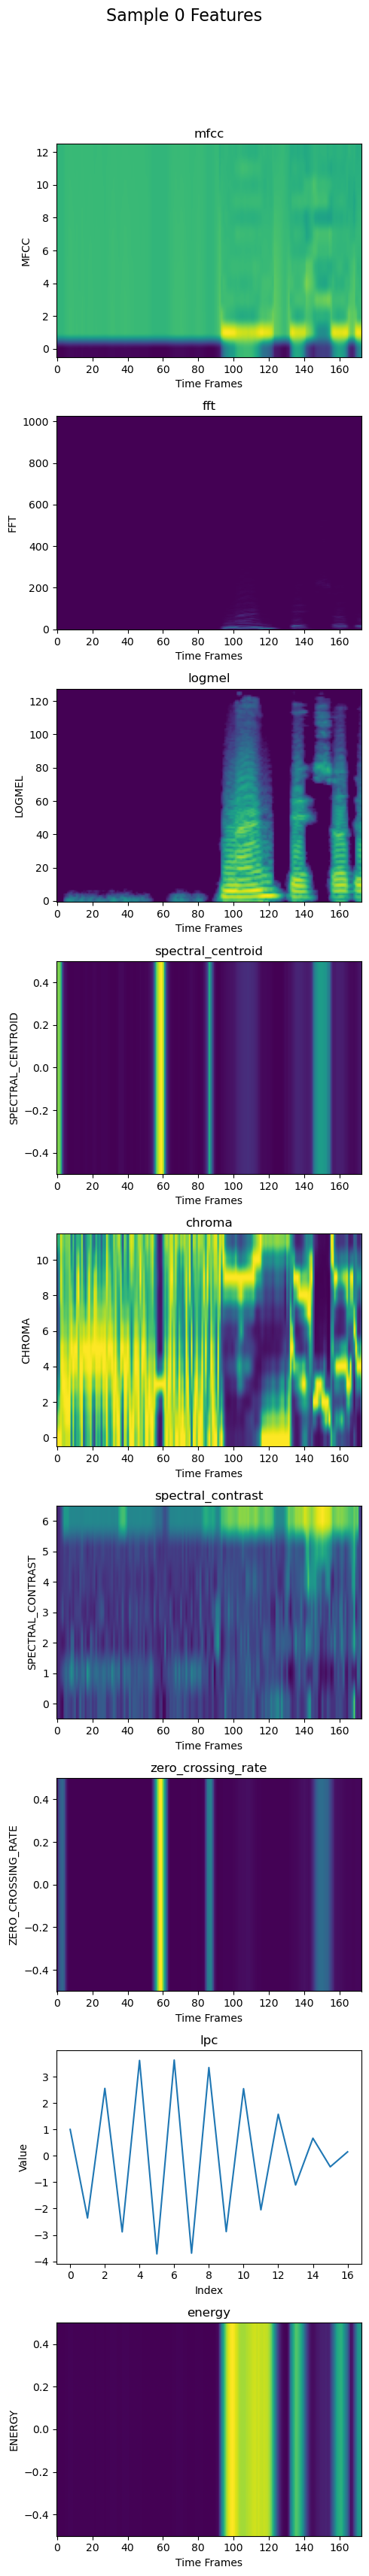

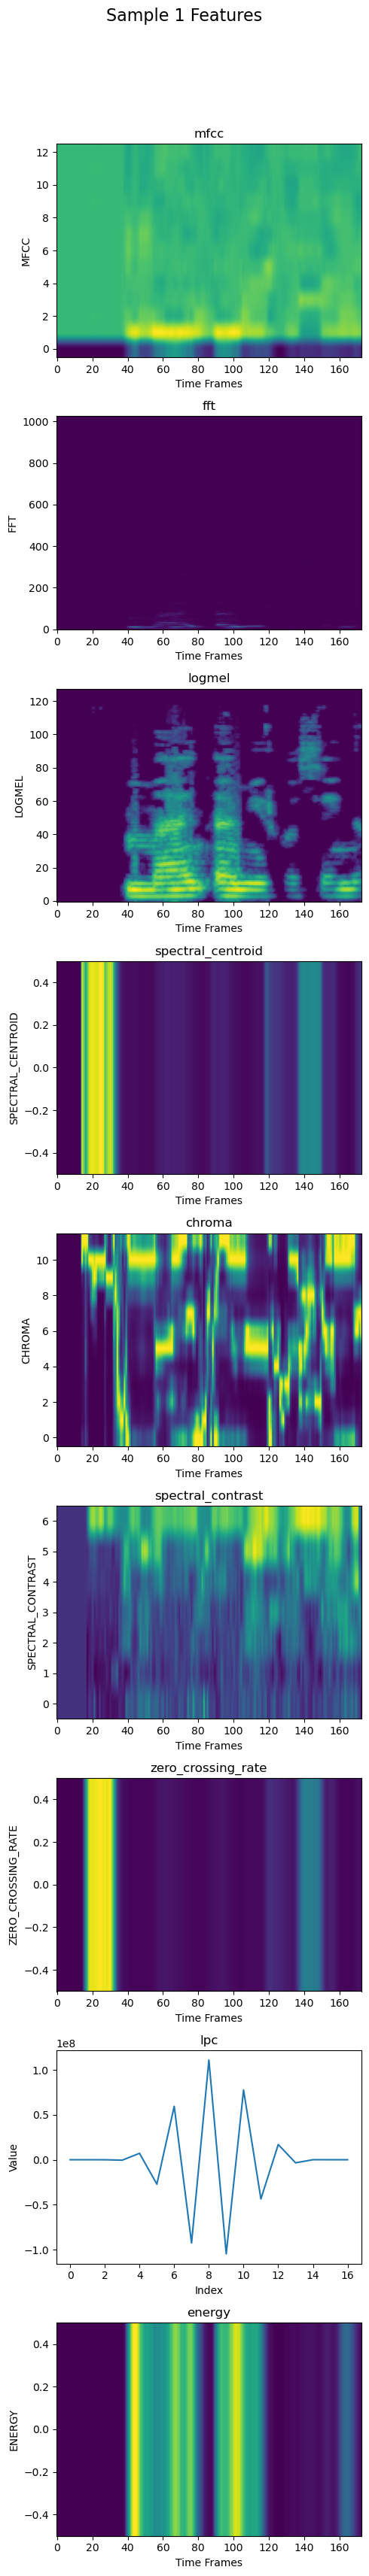

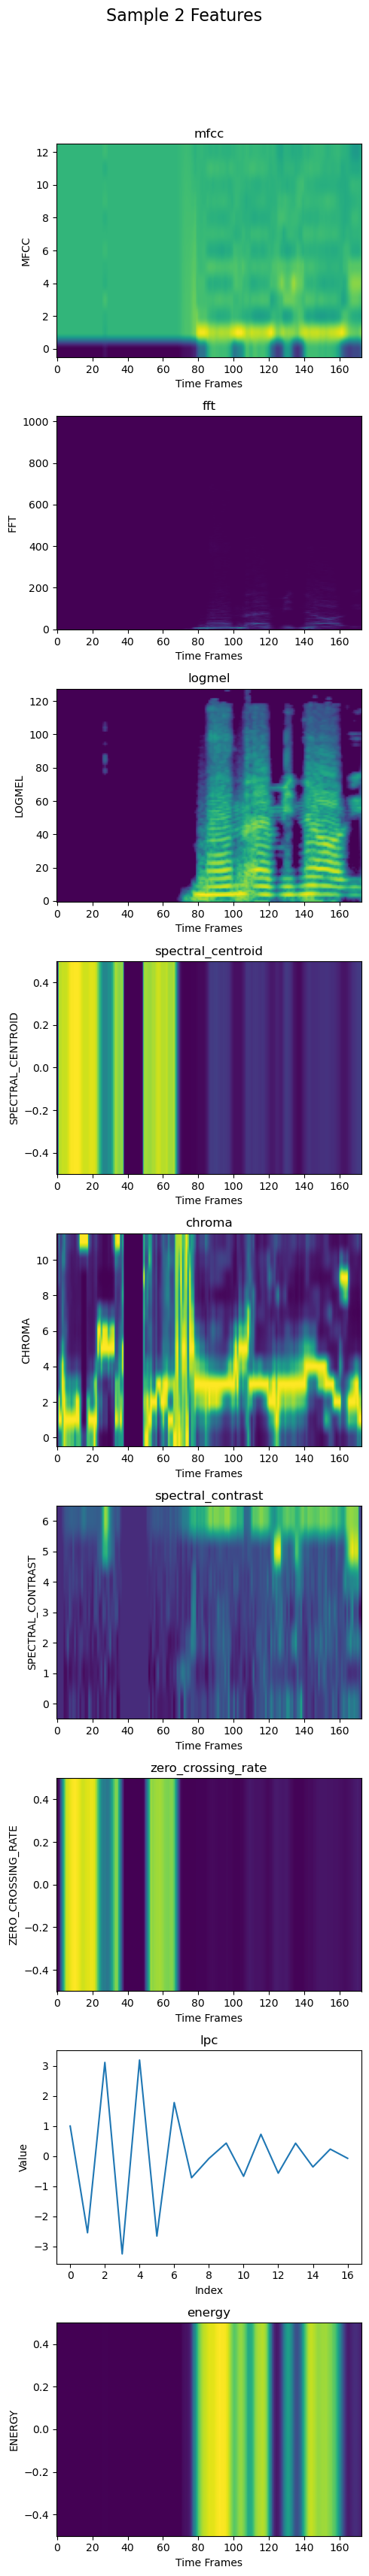

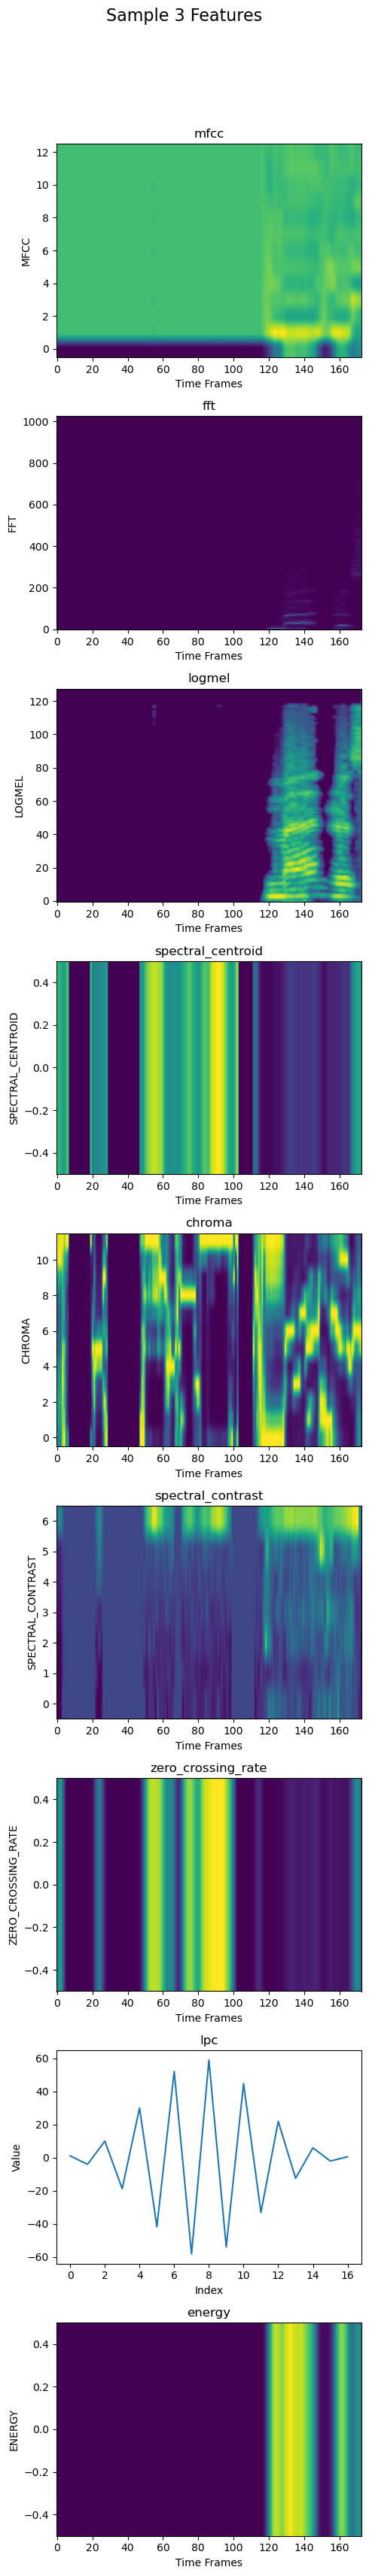

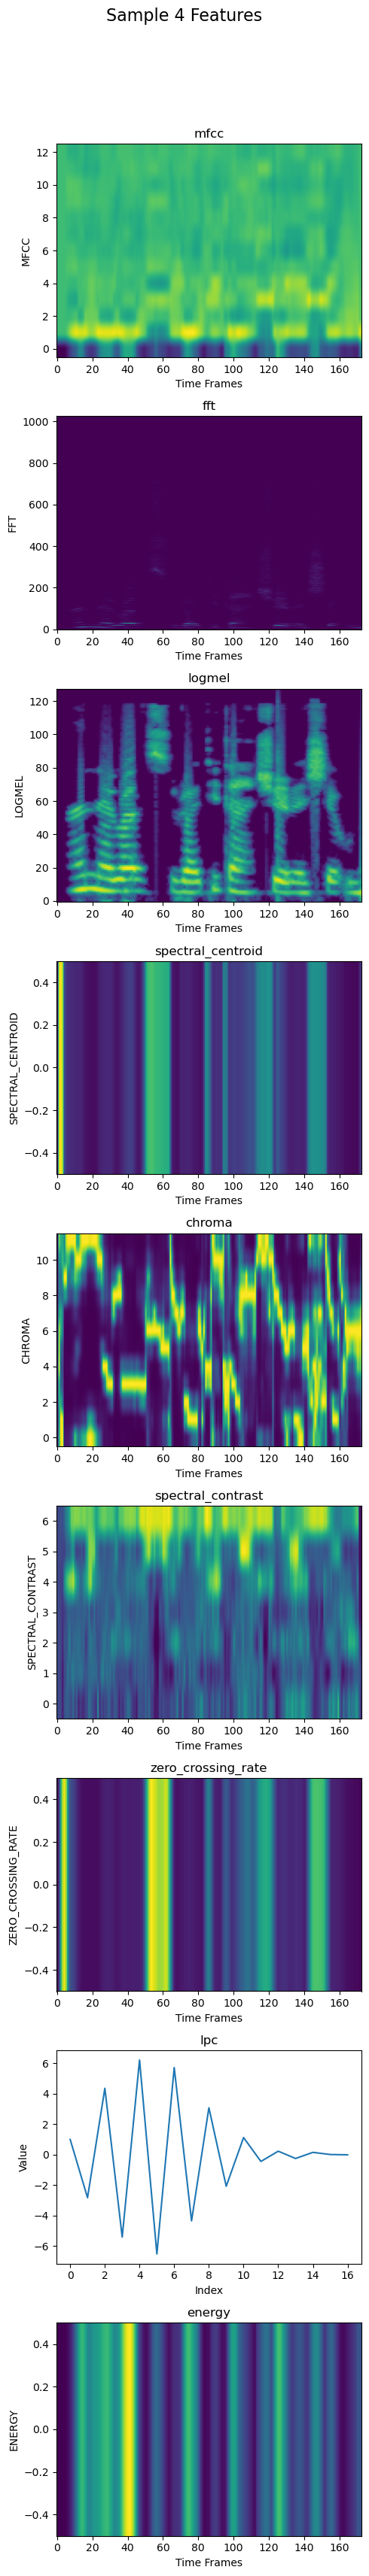

In [62]:
myData.plot_first_five_all_features()

In [59]:
myData.extract_and_save_all_features()


Extracting and saving features for all samples...


100%|██████████| 676/676 [7:34:30<00:00, 40.34s/it]   

Feature extraction and saving complete.


In [7]:
dataset_extracted = AudioDataset(root_dir="../../preprocessed",
                                task="gender",
                                preprocessed_dir="../../preprocessed",
                                save_features_dir="../../features1",
                                use_extracted_features=True)
    
sample_extracted = dataset_extracted[0]
print("Sample Metadata (Extracted):", sample_extracted["metadata"])
print("Loaded extracted features keys:", list(sample_extracted["features"].keys()))

Sample Metadata (Extracted): {'features_file': '../../features1\\HW1_Q1_151501033_male\\HW1_Q1_151501033_male_p0_features.npz', 'audio_file': '../../features1\\HW1_Q1_151501033_male\\HW1_Q1_151501033_male_p0.wav', 'homework_number': 1, 'question_number': 1, 'student_id': '151501033', 'gender': 'male', 'part': 0, 'base_filename': 'HW1_Q1_151501033_male'}
Loaded extracted features keys: ['mfcc', 'fft', 'logmel', 'spectral_centroid', 'chroma', 'spectral_contrast', 'zero_crossing_rate', 'lpc', 'energy']


In [74]:
myData = AudioDataset("../../HW1_M", preprocessed_dir="../../preprocessed")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../HW1_M'

In [ ]:
# myData.preprocess_and_save()

Processing Audio Files: 100%|██████████| 676/676 [06:31<00:00,  1.73it/s]


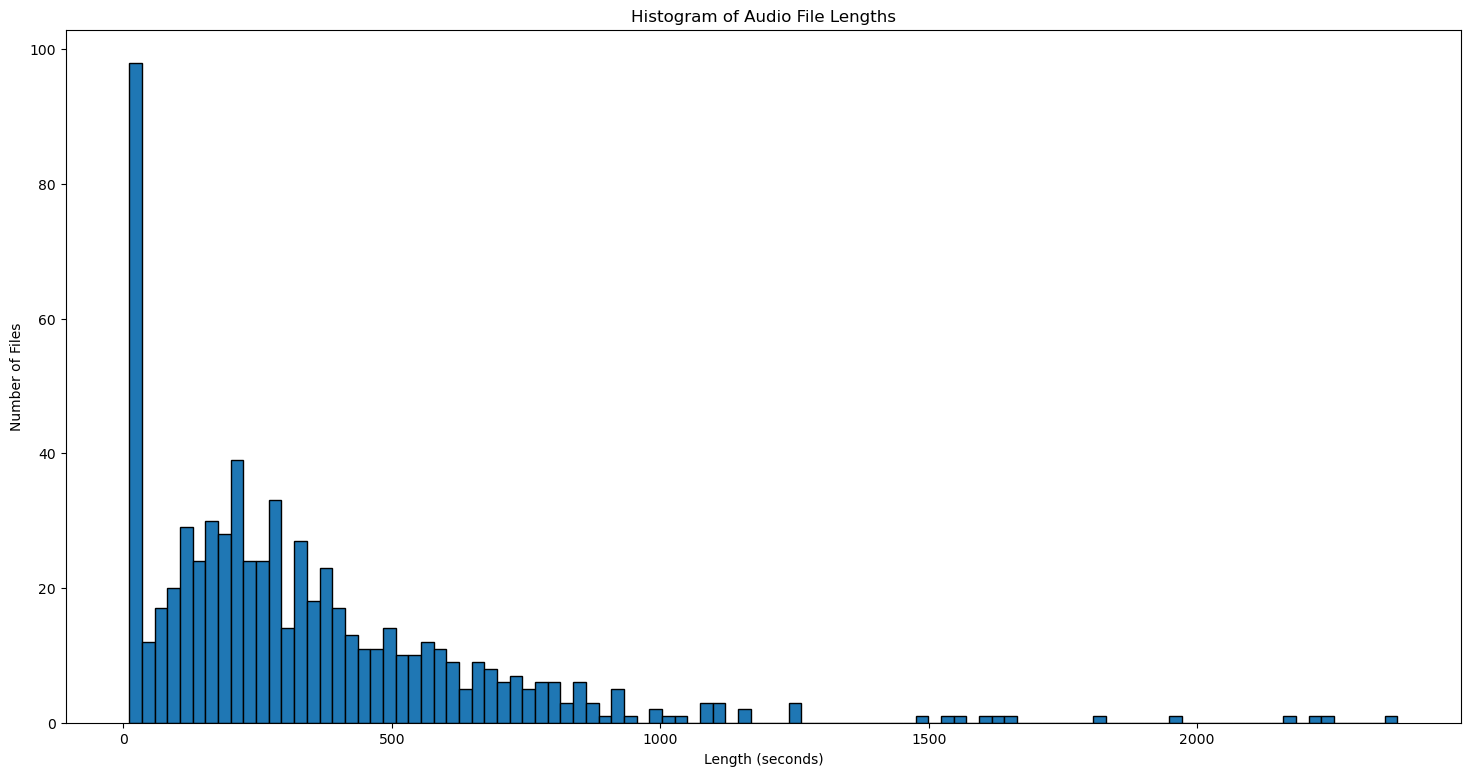

Minimum audio length: 10.87 seconds


In [21]:
myData.plot_audio_lengths()

In [27]:
def get_feature_vector(sample, feature_name="mfcc"):
    """
    Given a sample dictionary (from extracted-features mode),
    compute a 1D feature vector from the specified feature.
    For MFCC, we average each coefficient over time.
    """
    feat = sample["features"].get(feature_name, None)
    if feat is None:
        return None
    # If the feature is 2D (e.g. MFCC with shape (n_coeffs, time)), average over time axis.
    if feat.ndim == 2:
        return np.max(feat, axis=1)
    elif feat.ndim == 1:
        return feat
    else:
        raise ValueError("Unsupported feature dimensions.")

def collect_fixed_samples(dataset, feature_name="mfcc", n_target=50):
    """
    Loop over the dataset (assumed to be in extracted-features mode) and collect exactly
    up to n_target samples per gender. The loop stops when both genders have reached the target.
    """
    male_samples = []
    female_samples = []
    for sample in dataset:
        # Ensure the feature exists in the sample.
        if sample["features"].get(feature_name) is None:
            continue
        gender = sample["metadata"]["gender"]
        if gender == "male" and len(male_samples) < n_target:
            male_samples.append(sample)
        elif gender == "female" and len(female_samples) < n_target:
            female_samples.append(sample)
        if len(male_samples) >= n_target and len(female_samples) >= n_target:
            break
    return male_samples, female_samples

In [28]:
male_samples, female_samples = collect_fixed_samples(dataset_extracted, feature_name="mfcc", n_target=500)


In [29]:
all_vectors = []
all_labels = []

for sample in male_samples:
    vec = get_feature_vector(sample, feature_name="mfcc")
    if vec is not None:
        all_vectors.append(vec)
        all_labels.append("male")

for sample in female_samples:
    vec = get_feature_vector(sample, feature_name="mfcc")
    if vec is not None:
        all_vectors.append(vec)
        all_labels.append("female")

all_vectors = np.array(all_vectors)
all_labels = np.array(all_labels)

print("Collected", all_vectors.shape[0], "samples with feature vectors of shape", all_vectors.shape[1])

Collected 1000 samples with feature vectors of shape 13


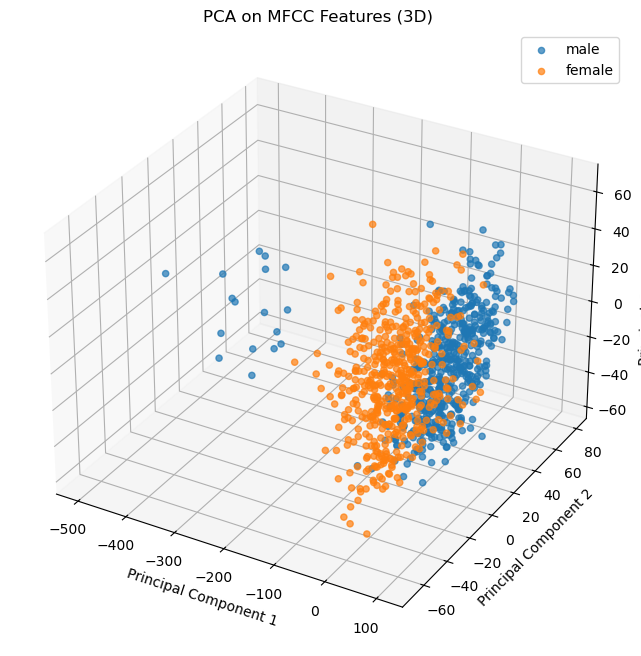

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Perform PCA with 3 components
pca = PCA(n_components=3)
all_pca = pca.fit_transform(all_vectors)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points for each gender
for gender in ["male", "female"]:
    idx = all_labels == gender
    ax.scatter(all_pca[idx, 0], all_pca[idx, 1], all_pca[idx, 2], label=gender, alpha=0.7)

ax.set_title("PCA on MFCC Features (3D)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend()
plt.show()


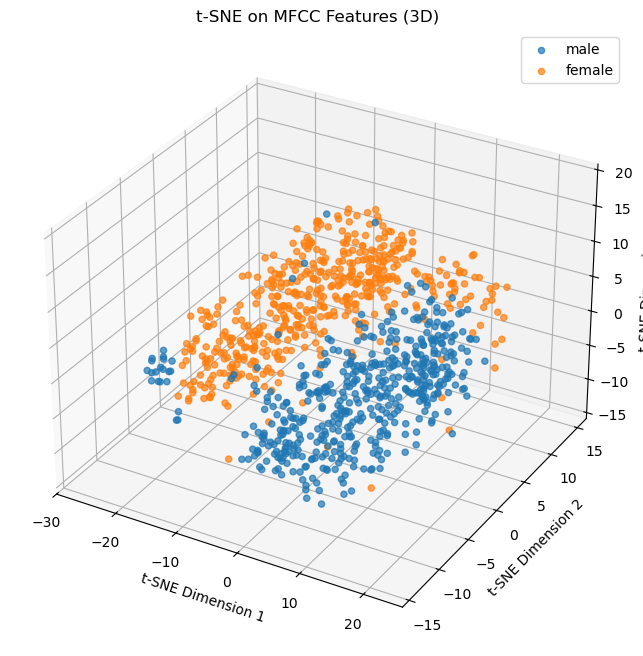

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Perform t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42)
all_tsne = tsne.fit_transform(all_vectors)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points for each gender
for gender in ["male", "female"]:
    idx = all_labels == gender
    ax.scatter(all_tsne[idx, 0], all_tsne[idx, 1], all_tsne[idx, 2], label=gender, alpha=0.7)

ax.set_title("t-SNE on MFCC Features (3D)")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")
ax.legend()
plt.show()


In [34]:
data_loader = DataLoader(dataset_extracted, batch_size=1, shuffle=False)

In [ ]:
feature_vectors = []
sample_ids = []  # to keep track of the samples

print("Building feature matrix from dataset...")
for idx in tqdm(range(len(dataset_extracted))):
    sample = dataset_extracted[idx]
    features = sample["features"]
    
    # For extracted features mode, features is a dictionary containing keys such as 'mfcc', etc.
    if 'mfcc' in features and features['mfcc'] is not None:
        mfcc = features['mfcc']  # Expected shape: (n_mfcc, time_frames)
        # Compute the mean and maximum along the time axis (axis=1)
        mfcc_mean = np.mean(mfcc, axis=1)  # shape: (n_mfcc,)
        mfcc_max = np.max(mfcc, axis=1)    # shape: (n_mfcc,)
        # Concatenate the features to form a vector of size (n_mfcc * 2,)
        feature_vector = np.concatenate([mfcc_mean, mfcc_max])
        feature_vectors.append(feature_vector)
        sample_ids.append(idx)
    else:
        print(f"Sample {idx} does not have MFCC features.")

Building feature matrix from dataset...


  0%|          | 0/17921 [00:00<?, ?it/s]

 99%|█████████▉| 17816/17921 [1:44:50<00:37,  2.83it/s]   


BadZipFile: Overlapped entries: 'fft.npy' (possible zip bomb)

In [39]:
X = np.array(feature_vectors)
print("Feature matrix shape:", X.shape)

Feature matrix shape: (17816, 26)


In [40]:
print("\nPerforming KMeans clustering and evaluating silhouette scores...")
best_k = None
best_silhouette = -1
silhouette_scores = {}

# Test k values in the range 2 to 10 (adjust as needed)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores[k] = score
    print(f"KMeans: k = {k}, silhouette score = {score:.4f}")
    if score > best_silhouette:
        best_silhouette = score
        best_k = k

print(f"\nBest k found for KMeans: {best_k} (silhouette score = {best_silhouette:.4f})")
# Fit KMeans with best k:
kmeans_best = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans_best.fit_predict(X)


Performing KMeans clustering and evaluating silhouette scores...
KMeans: k = 2, silhouette score = 0.2159
KMeans: k = 3, silhouette score = 0.1435
KMeans: k = 4, silhouette score = 0.1141
KMeans: k = 5, silhouette score = 0.1074
KMeans: k = 6, silhouette score = 0.1022
KMeans: k = 7, silhouette score = 0.0957
KMeans: k = 8, silhouette score = 0.1006
KMeans: k = 9, silhouette score = 0.0950
KMeans: k = 10, silhouette score = 0.0904

Best k found for KMeans: 2 (silhouette score = 0.2159)


In [58]:
def compute_cluster_centroids(X, labels):
    unique_labels = np.unique(labels)
    centroids = {}
    for label in unique_labels:
        centroids[label] = X[labels == label].mean(axis=0)
    return centroids

def analyze_cluster_separation(centroids):
    labels = list(centroids.keys())
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            centroid_i = centroids[labels[i]]
            centroid_j = centroids[labels[j]]
            distance = np.linalg.norm(centroid_i - centroid_j)
            print(f"Distance between cluster {labels[i]} and cluster {labels[j]}: {distance:.4f}")

Distance between cluster 0 and cluster 1: 83.9317


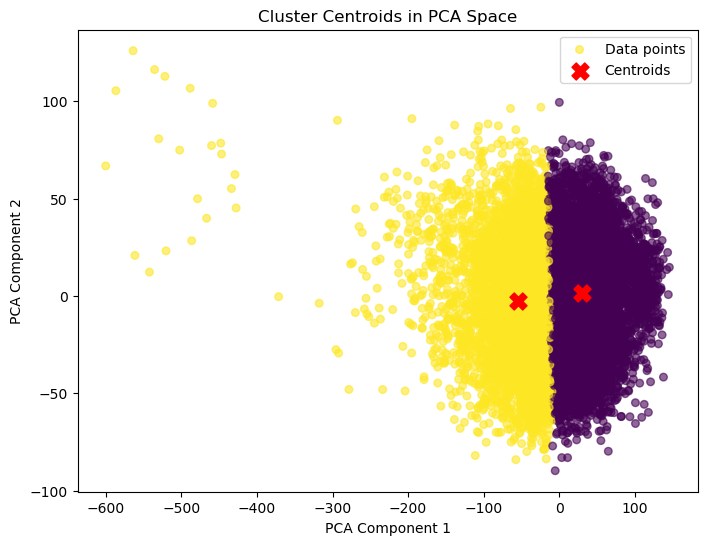

In [60]:
centroids = compute_cluster_centroids(X, kmeans_labels)
analyze_cluster_separation(centroids)

# (Optional) Visualize centroids in PCA-reduced space:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
centroid_points = np.array([centroids[label] for label in sorted(centroids.keys())])
centroid_2d = pca.transform(centroid_points)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_labels, cmap='viridis', s=30, alpha=0.6, label="Data points")
plt.scatter(centroid_2d[:, 0], centroid_2d[:, 1], c='red', s=150, marker='X', label="Centroids")
plt.title("Cluster Centroids in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

Cluster 0: Avg. intra-cluster distance = 92.4212
Cluster 1: Avg. intra-cluster distance = 102.8945


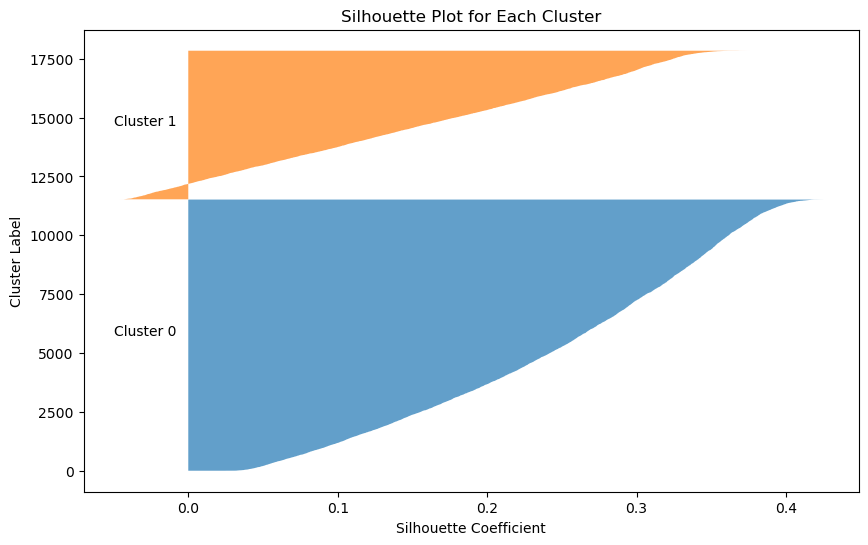

Overall silhouette score: 0.2159


In [56]:
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

def analyze_cluster_cohesion(X, labels):
    unique_labels = np.unique(labels)
    cluster_cohesions = {}
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        # Compute pairwise distances within the cluster:
        if len(cluster_points) > 1:
            distances = pairwise_distances(cluster_points)
            # We remove the diagonal (distance=0) by using a mask.
            mask = ~np.eye(len(cluster_points), dtype=bool)
            avg_distance = distances[mask].mean()
            cluster_cohesions[label] = avg_distance
            print(f"Cluster {label}: Avg. intra-cluster distance = {avg_distance:.4f}")
        else:
            cluster_cohesions[label] = 0.0
            print(f"Cluster {label}: Only one sample.")

    # Silhouette scores for each sample:
    sample_silhouette_values = silhouette_samples(X, labels)
    
    plt.figure(figsize=(10, 6))
    y_lower = 10
    for label in unique_labels:
        cluster_silhouette = sample_silhouette_values[labels == label]
        cluster_silhouette.sort()
        size_cluster = cluster_silhouette.shape[0]
        y_upper = y_lower + size_cluster
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster, f"Cluster {label}")
        y_lower = y_upper + 10
    plt.title("Silhouette Plot for Each Cluster")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster Label")
    plt.show()
    
    # Overall silhouette score:
    overall_score = silhouette_score(X, labels)
    print(f"Overall silhouette score: {overall_score:.4f}")
    
    return cluster_cohesions

# Assume X is our feature matrix and hierarchical_labels are our cluster assignments:
cluster_cohesions = analyze_cluster_cohesion(X, kmeans_labels)


In [53]:
print("\nPerforming Hierarchical (Agglomerative) Clustering and evaluating silhouette scores...")
best_n_clusters = None
best_silhouette = -1
silhouette_scores = {}

# Test number of clusters in the range 2 to 10 (adjust as needed)
for n_clusters in range(2, 11):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = hierarchical.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores[n_clusters] = score
    print(f"Hierarchical Clustering: n_clusters = {n_clusters}, silhouette score = {score:.4f}")
    if score > best_silhouette:
        best_silhouette = score
        best_n_clusters = n_clusters

print(f"\nBest number of clusters for Hierarchical Clustering: {best_n_clusters} (silhouette score = {best_silhouette:.4f})")
# Fit the best hierarchical clustering model:
hierarchical_best = AgglomerativeClustering(n_clusters=best_n_clusters, linkage='ward')
hierarchical_labels = hierarchical_best.fit_predict(X)


Performing Hierarchical (Agglomerative) Clustering and evaluating silhouette scores...
Hierarchical Clustering: n_clusters = 2, silhouette score = 0.1482
Hierarchical Clustering: n_clusters = 3, silhouette score = 0.1048
Hierarchical Clustering: n_clusters = 4, silhouette score = 0.0503
Hierarchical Clustering: n_clusters = 5, silhouette score = 0.0525
Hierarchical Clustering: n_clusters = 6, silhouette score = 0.0502
Hierarchical Clustering: n_clusters = 7, silhouette score = 0.0483
Hierarchical Clustering: n_clusters = 8, silhouette score = 0.0489
Hierarchical Clustering: n_clusters = 9, silhouette score = 0.0438
Hierarchical Clustering: n_clusters = 10, silhouette score = 0.0405

Best number of clusters for Hierarchical Clustering: 2 (silhouette score = 0.1482)



Generating dendrogram...


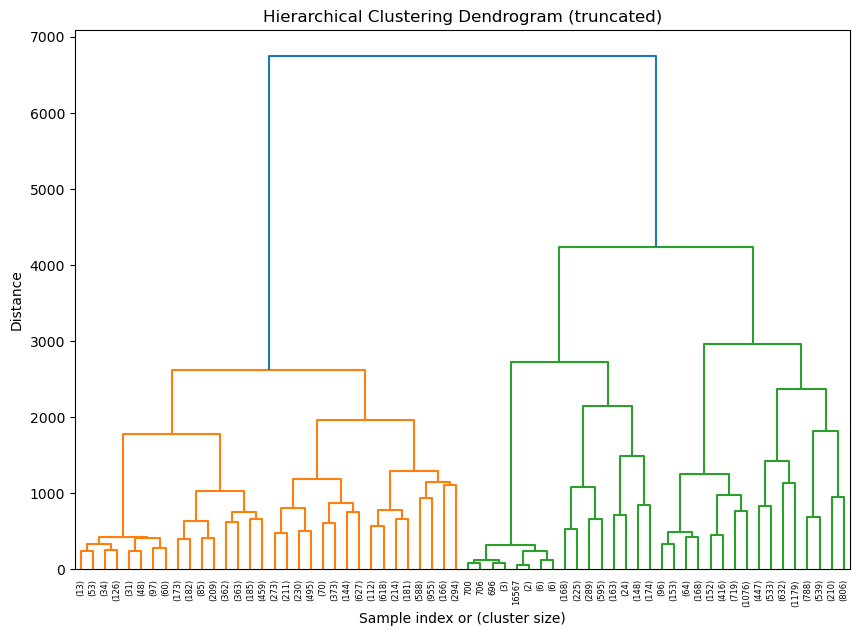

In [61]:
# ---------------------------------------------------
# (Optional) Plot a Dendrogram to visualize the hierarchical clustering
# ---------------------------------------------------
print("\nGenerating dendrogram...")
# For the dendrogram, we use SciPy's linkage method. Note that this computes the full linkage
# which may be memory-intensive for large datasets.
Z = linkage(X, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5)  # p controls the depth of the dendrogram
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.show()

Cluster 0: Avg. intra-cluster distance = 103.4551
Cluster 1: Avg. intra-cluster distance = 92.8030


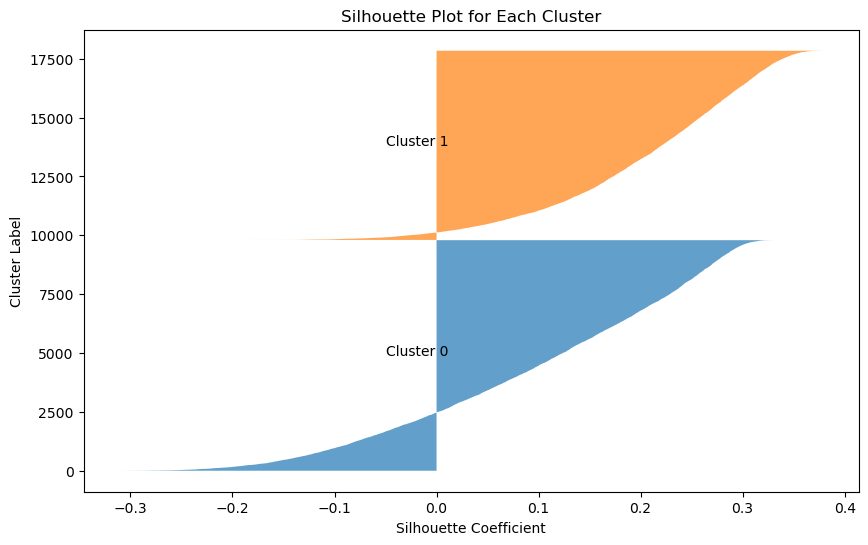

Overall silhouette score: 0.1482


In [57]:
cluster_cohesions = analyze_cluster_cohesion(X, hierarchical_labels)


Distance between cluster 0 and cluster 1: 71.8652


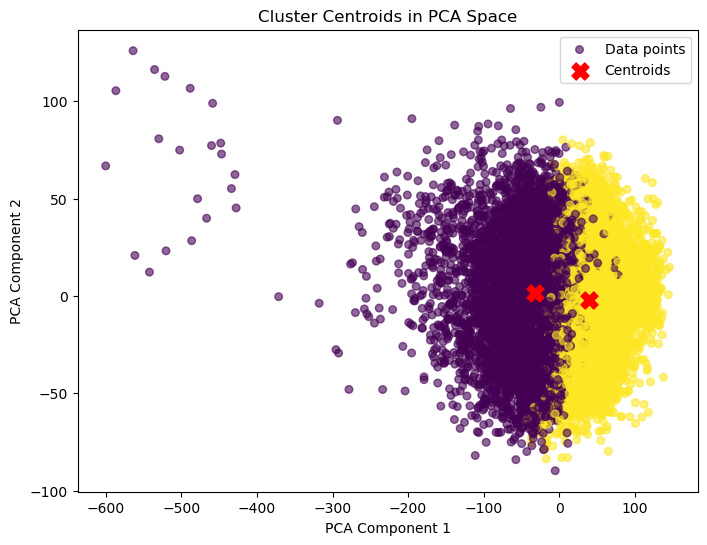

In [59]:
# Compute centroids
centroids = compute_cluster_centroids(X, hierarchical_labels)
analyze_cluster_separation(centroids)

# (Optional) Visualize centroids in PCA-reduced space:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
centroid_points = np.array([centroids[label] for label in sorted(centroids.keys())])
centroid_2d = pca.transform(centroid_points)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=hierarchical_labels, cmap='viridis', s=30, alpha=0.6, label="Data points")
plt.scatter(centroid_2d[:, 0], centroid_2d[:, 1], c='red', s=150, marker='X', label="Centroids")
plt.title("Cluster Centroids in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()
